<a href="https://colab.research.google.com/github/dc480506/SHALA2020/blob/master/ML_L1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 1** (Intro to Machine Learning)

## Note:

* The dataset to be used is `attrition.csv`. This dataset reveals whether a particular employee left the company or not.  
* In this dataset, the column named `Attrition` is the target variable and the remaining columns are features. Please note that `Attrition = 1` means the employee left the company, whereas `Attrition = 0` means the opposite of this statement. 
*  This dataset has been loaded in this assignment as shown below. In case, you are not able to load this data, please note that this data is stored separately as well in the assignment folder. 

## Instructions:

* You are required to use a classifier, which can predict the `Attrition` for the employees. 
* Before implementing any model, you will have to apply suitable encoding to the features and implement exploratory data analysis to know your data better. 
* You can either define your own custom-made classifer or select classifier(s) available in the `scikit-learn`.
* You are supposed to implement a minimum of three classifiers (e.g.  `RandomForestClassifier`, `XGBClassifier`, `DecisionTreeClassifier`, `KNeighborsClassifier`, etc.) and evaluate which one is giving the best peformance. 
* For each of the classifier,  report the accuracy, precision, recall, roc curve, etc. 

In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import preprocessing 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data_url = "https://raw.githubusercontent.com/shala2020/shala2020.github.io/master/Lecture_Materials/Assignments/MachineLearning/L1/attrition.csv"
attrition_data = pd.read_csv(data_url)
attrition_data.isna().isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
ID        

In [0]:
def encode_Features(df,target_col):
  categorical_col=[]
  for column in df:
    if((type(df[column][0]) is str or type(df[column][0]) is bool) and column!=target_col ):
      mapper={}
      categorical_col.append(column)
      uniq_val=list(df[column].unique())
      i=0
      for val in uniq_val:
        mapper[val]=i
        i=i+1
      df[column]=df[column].map(mapper)
  return categorical_col
def dropCols(df,threshold_corr,target_col):
  drop_cols=[]
  for column in attrition_data:
    if column!=target_col and abs(df[column].corr(df[target_col]))<threshold_corr:
      drop_cols.append(column)
  return drop_cols

Categorical Columns:  ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
Dropped Columns:  ['BusinessTravel', 'EmployeeNumber', 'Gender', 'HourlyRate', 'MonthlyRate', 'PercentSalaryHike', 'PerformanceRating', 'ID', 'EmployeeCount']


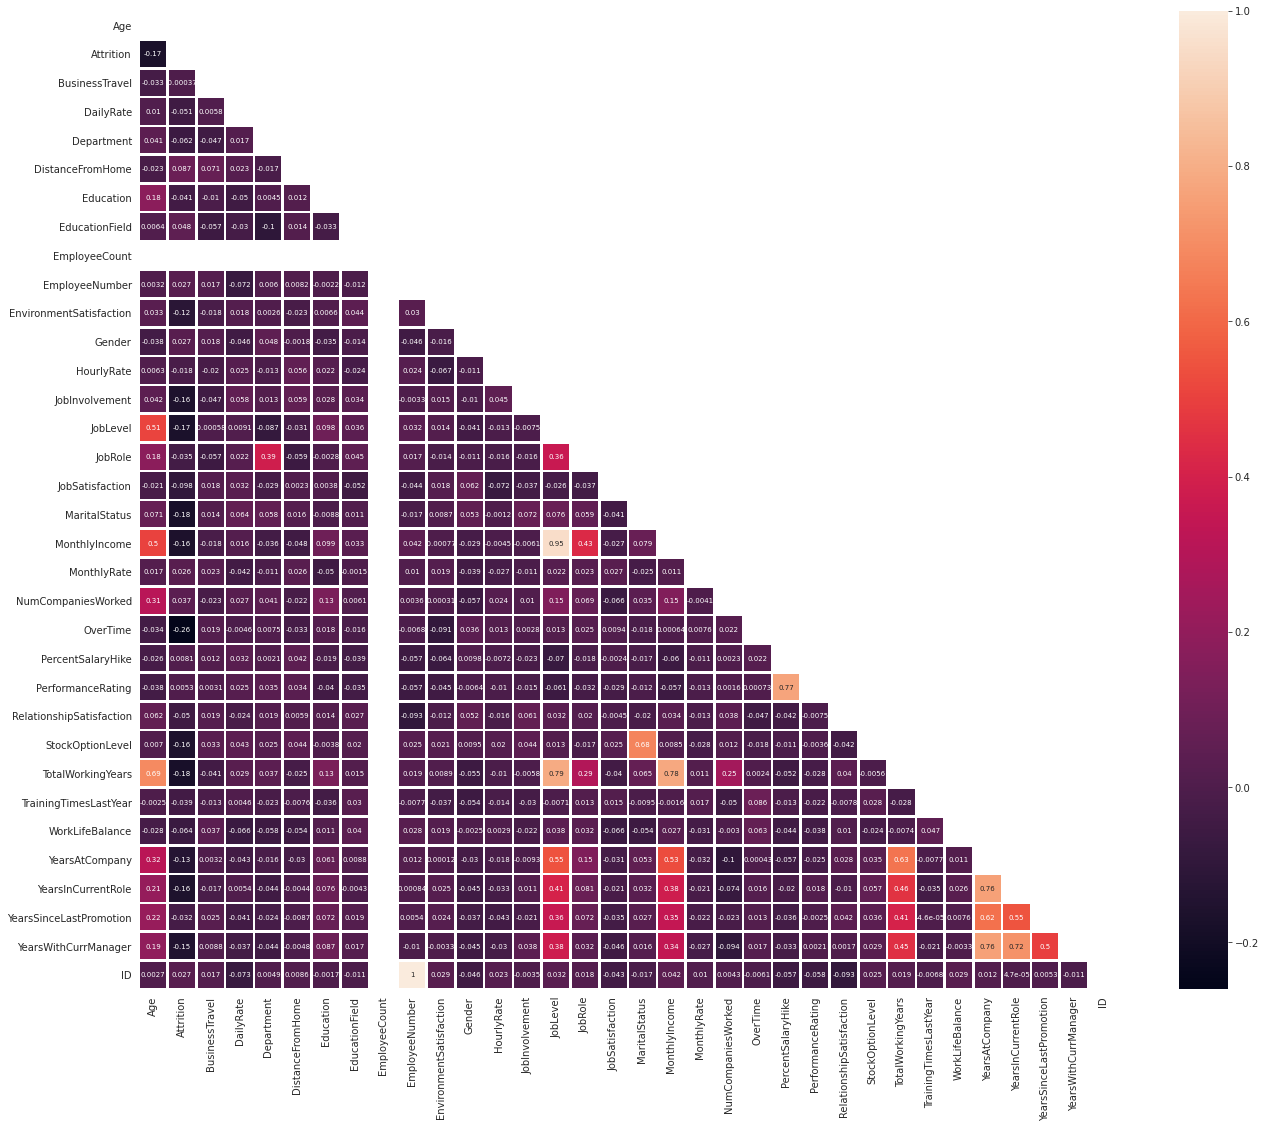

In [201]:
# attrition_data['BusinessTravel'].value_counts()
# map_Business_Travel={"Travel_Rarely":0,"Travel_Frequently":1, "Non-Travel":2}
# attrition_data['BusinessTravel']=attrition_data['BusinessTravel'].map(map_Business_Travel)
temp_attrition_data=attrition_data.copy()
categorical_col=encode_Features(temp_attrition_data,'Attrition')
# Heatmap
corr=temp_attrition_data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(22, 18))
    ax = sns.heatmap(corr, mask=mask,annot=True,linewidths=1.5 ,annot_kws={'size':7},square=True)

print("Categorical Columns: ",categorical_col)
drop_cols=dropCols(temp_attrition_data,0.03,'Attrition')
drop_cols.append('EmployeeCount')
print("Dropped Columns: ",drop_cols)
# for col in temp_attrition_data:
#   if col!='Attrition':
#     print(col+": "+str(temp_attrition_data[col].corr(temp_attrition_data['Attrition'])))


In [163]:
temp_attrition_data=attrition_data.drop(drop_cols,axis=1)
categorical_col=[x for x in categorical_col if x not in drop_cols]
print(categorical_col)
temp_attrition_data.head()

['Department', 'EducationField', 'JobRole', 'MaritalStatus', 'OverTime']


,Age,Attrition,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,1102,Sales,1,2,Life Sciences,2,3,2,Sales Executive,4,Single,5993,8,Yes,1,0,8,0,1,6,4,0,5
1,49,0,279,Research & Development,8,1,Life Sciences,3,2,2,Research Scientist,2,Married,5130,1,No,4,1,10,3,3,10,7,1,7
2,37,1,1373,Research & Development,2,2,Other,4,2,1,Laboratory Technician,3,Single,2090,6,Yes,2,0,7,3,3,0,0,0,0
3,33,0,1392,Research & Development,3,4,Life Sciences,4,3,1,Research Scientist,3,Married,2909,1,Yes,3,0,8,3,3,8,7,3,0
4,27,0,591,Research & Development,2,1,Medical,1,3,1,Laboratory Technician,2,Married,3468,9,No,4,1,6,3,3,2,2,2,2


In [0]:
min_max_scaler=preprocessing.MinMaxScaler(feature_range=(0,1))
# drop_cols=[]
X=attrition_data.drop(drop_cols+['Attrition'],axis=1)
X_scale=X[[col for col in X if col not in categorical_col]] #features to scale
# scaled_cols=list(X_scale.columns)
x_min_max_scaler=min_max_scaler.fit_transform(X_scale) 
X_categorical=pd.get_dummies(X[categorical_col],prefix_sep='_',drop_first=True) # One hot encoding for categorical data
# categorical_col_after_dummies=list(X_categorical.columns)
X_final=np.concatenate((x_min_max_scaler,X_categorical.to_numpy()),axis=1)
# print(X_final)
# print(type(x_min_max_scaler))
y=attrition_data['Attrition']
X_train,X_test,y_train,y_test=train_test_split(X_final,y,test_size=0.2,random_state=131)
# print(np.count_nonzero(y_train==0))
# print(np.count_nonzero(y_train==1))

# Random Forest Classifer


In [0]:
rfr = RandomForestRegressor()
rfr.get_params


<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

Grid parameters for Random Forest Classifier

In [0]:
from sklearn.model_selection import GridSearchCV

In [97]:
rfr=RandomForestClassifier()
param_grid={
    'bootstrap':[True],
    'max_depth':range(20,100,20),
    'n_estimators':range(20,160,20),
    'max_features':[2,3,4,6,8],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    
}
grid_search=GridSearchCV(estimator=rfr,param_grid=param_grid,cv=5,n_jobs=30,verbose=True,scoring='roc_auc')
grid_search.fit(X_train,y_train)
grid_search.best_params_

Fitting 5 folds for each of 1260 candidates, totalling 6300 fits


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:   35.0s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:  1.1min
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:  1.9min
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:  2.9min
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:  4.2min
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:  5.7min
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:  7.5min
[Parallel(n_jobs=30)]: Done 3990 tasks      | elapsed:  9.3min
[Parallel(n_jobs=30)]: Done 4940 tasks      | elapsed: 11.5min
[Parallel(n_jobs=30)]: Done 5990 tasks      | elapsed: 13.9min
[Parallel(n_jobs=30)]: Done 6300 out of 6300 | elapsed: 14.7min finished


{'bootstrap': True,
 'max_depth': 60,
 'max_features': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

In [101]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Testing Accuracy score: 0.8204
[[164   4]
 [ 33   5]]
****************************************
              precision    recall  f1-score   support

           0       0.83      0.98      0.90       168
           1       0.56      0.13      0.21        38

    accuracy                           0.82       206
   macro avg       0.69      0.55      0.56       206
weighted avg       0.78      0.82      0.77       206

AUC for Random Forest is: 0.8106203007518796


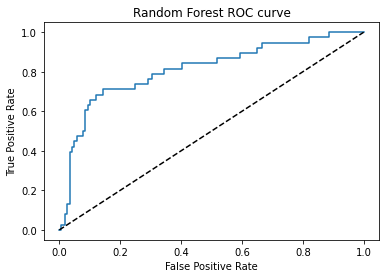

In [175]:
rfr_actual=RandomForestClassifier(
    bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features=6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False
                       )
# rfr_actual=RandomForestClassifier()
rfr_actual.fit(X_train,y_train)
# print("Training Accuracy score: "+str(round(accuracy_score(y_train,rfr_actual.predict(X_train).round()),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,rfr_actual.predict(X_test).round()),4)))
print(confusion_matrix(y_test,rfr_actual.predict(X_test)))
print("*"*40)
print(classification_report(y_test,rfr_actual.predict(X_test)))
probs = rfr_actual.predict_proba(X_test)  
probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC curve')
print("AUC for Random Forest is: "+str(auc(fper,tper)))

In [176]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=10, random_state=123,shuffle=True)
results = cross_val_score(rfr_actual, X_test, y_test, cv=kfold)
print(results)

[0.9047619  0.80952381 0.85714286 0.85714286 0.80952381 0.9047619
 0.6        0.7        0.8        0.95      ]


Accuracy: 81.93% (9.87%)


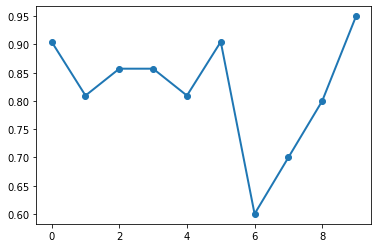

In [177]:
plt.plot(np.arange(10), results, 'o-', linewidth=2)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# XGBoost 


In [64]:
estimator = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = 42
)
parameters = {
    'max_depth': range (2, 33, 1),
    'n_estimators': range(0, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

Fitting 10 folds for each of 558 candidates, totalling 5580 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   20.2s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   58.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  3.6min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  5.5min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  7.2min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed: 10.2min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed: 12.9min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed: 16.5min
[Parallel(n_jobs=10)]: Done 5580 out of 5580 | elapsed: 18.7min finished


({'learning_rate': 0.05, 'max_depth': 12, 'n_estimators': 160},
 0.8013082825103286)

In [65]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=160, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

Testing Accuracy score: 0.8544
[[163   5]
 [ 25  13]]
****************************************
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       168
           1       0.72      0.34      0.46        38

    accuracy                           0.85       206
   macro avg       0.79      0.66      0.69       206
weighted avg       0.84      0.85      0.83       206

AUC for XG B is: 0.8369360902255638


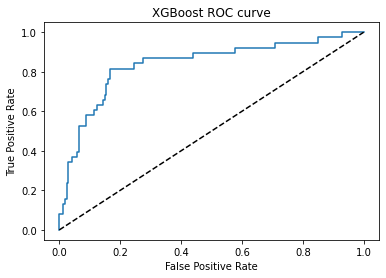

In [171]:

xgb_clf = xgb.XGBClassifier(
    # base_score=0.5, booster='gbtree', colsample_bylevel=1,
    #           colsample_bynode=1, colsample_bytree=1, gamma=0,
    #           learning_rate=0.05, max_delta_step=0, max_depth=12,
    #           min_child_weight=1, missing=None, n_estimators=160, n_jobs=1,
    #           nthread=None, objective='binary:logistic', random_state=0,
    #           reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
    #           silent=None, subsample=1, verbosity=1
              )
xgb_clf.fit(X_train,y_train)
# print("Training Accuracy score: "+str(round(accuracy_score(y_train,xgb_clf.predict(X_train).round()),4)))
print("Testing Accuracy score: "+str(round(accuracy_score(y_test,xgb_clf.predict(X_test).round()),4)))
print(confusion_matrix(y_test,xgb_clf.predict(X_test)))
print("*"*40)
print(classification_report(y_test,xgb_clf.predict(X_test)))
probs = xgb_clf.predict_proba(X_test)  
probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC curve')
print("AUC for XG B is: "+str(auc(fper,tper)))

In [98]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=10, random_state=123,shuffle=True)
results = cross_val_score(xgb_clf, X_test, y_test, cv=kfold)    #Cross Validation
print(results)

[1.         0.80952381 0.85714286 0.80952381 0.80952381 0.85714286
 0.6        0.8        0.8        0.95      ]


Accuracy: 82.93% (10.04%)


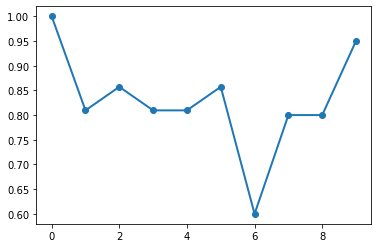

In [92]:
plt.plot(np.arange(10), results, 'o-', linewidth=2)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# KNeighbours Classifier

In [0]:
from sklearn.neighbors import KNeighborsClassifier


In [165]:
knc=KNeighborsClassifier()
param_grid={
    'n_neighbors':list(range(1,33))
}
grid_search = GridSearchCV(knc, param_grid, cv=10, scoring='roc_auc')
grid_search.fit(X_train,y_train)
grid_search.best_params_,grid_search.best_score_

({'n_neighbors': 32}, 0.7776153354318316)

In [166]:
grid_search.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=32, p=2,
                     weights='uniform')

Testing accuracy score: 0.82
[[168   0]
 [ 38   0]]
****************************************
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       168
           1       0.00      0.00      0.00        38

    accuracy                           0.82       206
   macro avg       0.41      0.50      0.45       206
weighted avg       0.67      0.82      0.73       206

AUC for Random Forest is: 0.7103696741854637


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


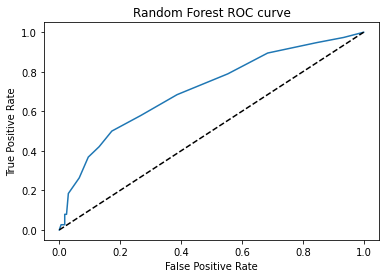

In [206]:
knc=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=32, p=2,
                     weights='uniform')
knc.fit(X_train,y_train)
print("Testing accuracy score: "+str(round(accuracy_score(knc.predict(X_test),y_test),2)))
print(confusion_matrix(y_test,knc.predict(X_test)))
print("*"*40)
print(classification_report(y_test,knc.predict(X_test)))
probs = knc.predict_proba(X_test)  
probs = probs[:, 1] 
fper, tper, thresholds = roc_curve(y_test, probs) 
plt.plot(fper, tper)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC curve')
print("AUC for Random Forest is: "+str(auc(fper,tper)))

In [0]:
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits=10, random_state=123,shuffle=True)
results = cross_val_score(knc, X_test, y_test, cv=kfold)        #Cross validation
print(results)

Accuracy: 81.00% (7.26%)


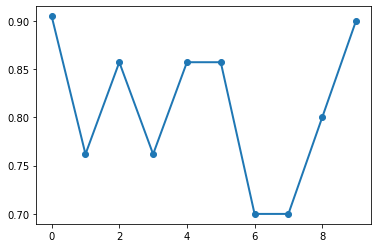

In [205]:
plt.plot(np.arange(10), results, 'o-', linewidth=2)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

## Resources:

* You might want to refer to the [lecture notebook](https://github.com/shala2020/shala2020.github.io/tree/master/Lecture_Materials/Google_Colab_Notebooks/MachineLearning/L1) for revising the concepts.
* You can also refer to the pre-work material for the first lecture on ML.  